In [17]:
from glob import glob
from pathlib import Path
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import wandb
from wandb.apis.public import Runs

keys = ["best_found", "n_oracle_calls"]

OPATH = Path("./data/runs3")
OPATH.mkdir(exist_ok=True, parents=True)

api = wandb.Api(timeout=30)
runs: Runs = api.runs("haydnj/lsbo2")
for run in runs:
    pl.DataFrame(run.history(keys=keys, samples=100000)).write_csv(OPATH / f"{run.id}.csv")

In [18]:
def load_and_preprocess_data(
    file_pattern: str, x_axis_key: str = "n_oracle_calls", y_axis_key: str = "best_found"
) -> tuple[pl.DataFrame, pl.DataFrame]:
    all_files = glob(file_pattern)
    if not all_files:
        raise ValueError(f"No files found matching the pattern: {file_pattern}")

    dataframes = []

    for i, file in enumerate(sorted(all_files)):
        df = pl.read_csv(file)
        if df.is_empty():
            print(f"Warning: Empty dataframe from file {file}")
            continue

        df = df.select(x_axis_key, y_axis_key)
        df = df.fill_null(strategy="backward").fill_null(strategy="forward")
        df = df.unique(x_axis_key, keep="last", maintain_order=True)

        df = df.rename({y_axis_key: f"{y_axis_key}_{i}"})
        dataframes.append(df)

    df = pl.concat(dataframes, how="align")
    df = df.fill_null(strategy="backward").fill_null(strategy="forward")

    x_axis = df.select(x_axis_key)
    y_vals = df.select([col for col in df.columns if y_axis_key in col])
    return x_axis, y_vals


def aggregate_and_plot_multiple(
    patterns: List[Tuple[str, str]],
    x_axis_key: str = "n_oracle_calls",
    y_axis_key: str = "best_found",
    log_x: bool = False,
    colors: Optional[List[str]] = None,
    output_file: Optional[str] = None,
) -> plt.Figure:  # type: ignore
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, (file_pattern, method_name) in enumerate(patterns):
        x_data, y_data = load_and_preprocess_data(file_pattern, x_axis_key, y_axis_key)

        x_data = x_data.to_numpy().flatten()

        mean = y_data.transpose().mean().to_numpy().flatten()
        std_err = y_data.transpose().std().to_numpy().flatten() / np.sqrt(len(y_data.columns))

        color = colors[i] if colors and i < len(colors) else None
        (line,) = ax.plot(x_data, mean, label=method_name, color=color)

        # Use the color of the line for fill_between if no color was explicitly provided
        fill_color = color if color else line.get_color()
        ax.fill_between(x_data, mean - std_err, mean + std_err, alpha=0.15, color=fill_color)

    ax.set_xlabel(x_axis_key)
    ax.set_ylabel(y_axis_key)
    ax.set_title("BO Trajectories")
    ax.legend()
    ax.grid(True)

    if log_x:
        ax.set_xscale("log")

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")

    return fig

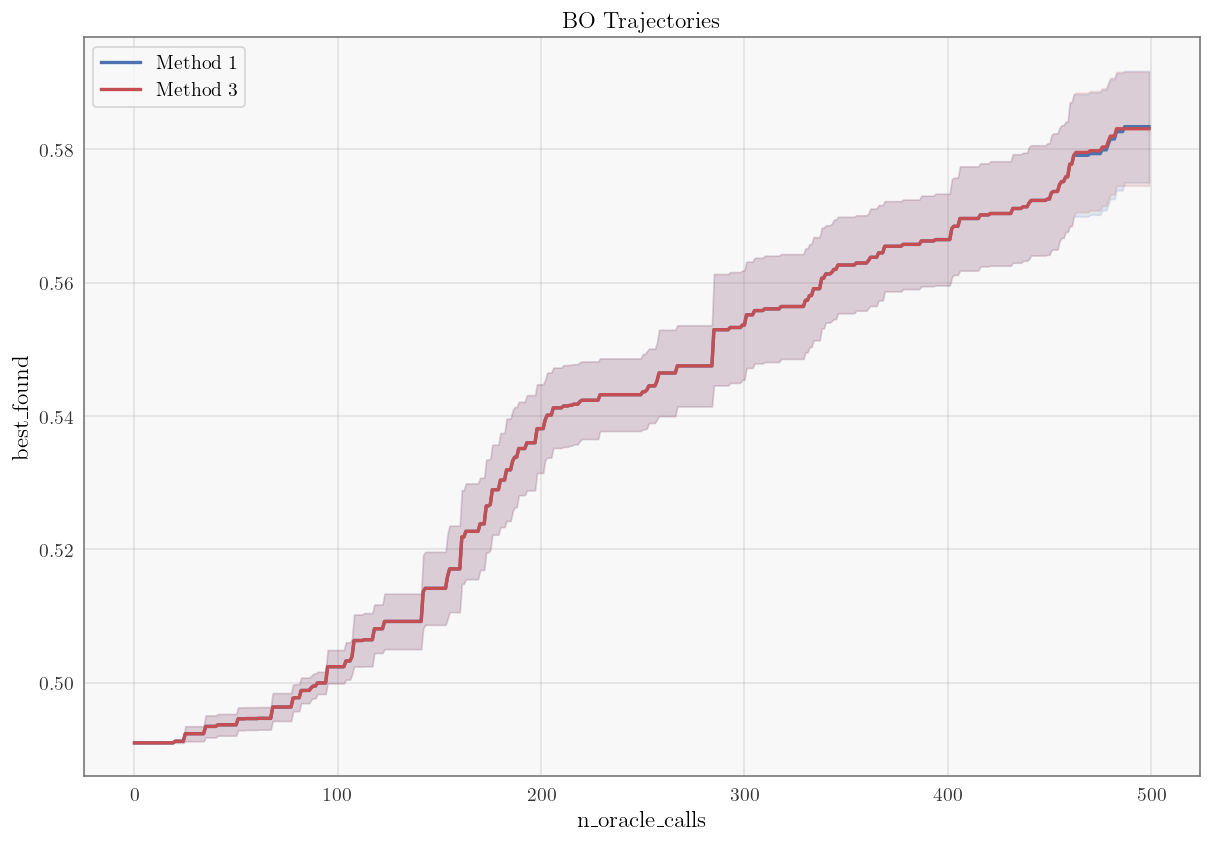

In [20]:
# Example usage
patterns = [
    ("./data/runs/*.csv", "Method 1"),
    ("./data/runs2/*.csv", "Method 2"),
    ("./data/runs3/*.csv", "Method 3"),
]

fig = aggregate_and_plot_multiple(
    patterns,
)
plt.show()